<a href="https://colab.research.google.com/github/christievanderuit/TM10007_group11/blob/main/TM10007_Group11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install sklearn numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# General packages
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
from scipy.stats import shapiro



# Classifiers
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn import feature_selection 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier




In [5]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git
data = pd.read_csv('/content/tm10007_ml/worcgist/GIST_radiomicFeatures.csv', index_col=0)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.
The number of samples: 246
The number of columns: 494


In [6]:
#zoeken van NaN --> want duidelijk dat deze erin zitten - ook voor de nu geplotte in de eerste figuur 
x_data = data.drop("label", axis='columns')


np.where(np.asanyarray(np.isnan(x_data))) 

# Find all entries that are not a number
x_data = x_data.apply(lambda x: pd.to_numeric(x, errors='coerce'))
nan_b = pd.isna(x_data)
n_nan = nan_b.sum().sum()
if n_nan > 0:
  nan = np.where(nan_b == "True")
else:
  nan = 0

#0'en zijn, dus deze droppen - dit zijn 6 kolommen 
df1 = x_data.mask(x_data != 0).dropna(axis=1)

df2 = x_data.copy()
for col in df1:
    df2 = df2.drop(col, axis=1)


In [7]:
#Splitsen in een train en in een testset 

#Waarbij x = features, y = label
y = data['label']
x = df2
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1, stratify=y)
#AFBLIJVEN VAN TESTDATA!!! :) 





In [8]:
# testen of er outliers zijn dmv LOF

lof = LocalOutlierFactor()
x_lof = lof.fit(x_train)
outlier_scores = x_lof.negative_outlier_factor_
threshold = np.mean(outlier_scores)
outliers = x_train[outlier_scores < threshold]
outlier_percentage = (len(outliers) / len(x_train)) * 100

print("Number of outliers:", len(outliers))
print("Percentage of outliers:", outlier_percentage)

Number of outliers: 9
Percentage of outliers: 4.591836734693878


In [9]:
# Test whether the data is normally distributed or not

# define a function to test for normality using the Shapiro-Wilk test
def test_normality(column):
    stat, p = shapiro(column)
    alpha = 0.05
    if p > alpha:
        return 1
    else:
        return 0

# apply the test_normality function to each column of the DataFrame
normality_results = x_train.apply(test_normality)

# combine the normalized and non-normalized data
scaler = preprocessing.RobustScaler()
scaler.fit(x_train)
x_scaled = pd.DataFrame(scaler.transform(x_train))

/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Functions for different feature extraction/selection methods

In [10]:
# PCA

def pca_func(X,n):
  # create PCA object with 2 components
  pca = PCA(n_components=n)

  # fit and transform the data
  df_pca = pca.fit_transform(X)
  return df_pca

In [11]:

def kbest_func(X, k):
    """
    Select the top k features using the f_regression score as the evaluation metric
    """
    # define the feature selector
    selector = SelectKBest(f_classif, k=k)
    
    # fit the selector to the training data and transform the data
    x_train_kbest = selector.fit_transform(X, y_train)
    return x_train_kbest

In [12]:
def rfe_func(X,k): 
    # Create a LabelEncoder object 
    le = LabelEncoder()

    # Fit the LabelEncoder object on the target variable (dit wordt gedaan omdat y_train uit alleen maar strings bestaat en dan kan je niet RFE gebruiken)
    y_train_encoded = le.fit_transform(y_train)

    # Create a logistic regression object
    lr = LinearRegression()

    # Create an RFE object and fit it on the training data
    rfe = RFE(estimator=lr, n_features_to_select=k)
    x_train_rfe = rfe.fit_transform(X, y_train_encoded)
    return x_train_rfe

In [13]:
# L1 regularization (Lasso regression)

def lasso_func(X,k):   
    # Create a LabelEncoder object
    le = LabelEncoder()

    # Fit the LabelEncoder object on the target variable
    y_train_encoded = le.fit_transform(y_train)

    # Lasso regression
    lasso = Lasso(alpha=k)
    
    # Create a SelectFromModel object and fit it on the training data
    selector = SelectFromModel(estimator=lasso)
    selector.fit(X, y_train_encoded)

    # Use the selector object to transform the data
    x_train_lasso = selector.transform(X)
    return x_train_lasso

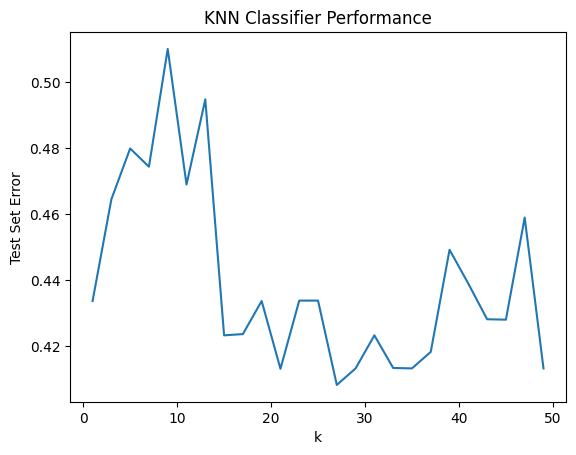

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]


In [14]:
# Pick k for KNN without feature extraction/selection
y_gist = pd.Series([1 if label == "GIST" else 0 for label in y_train], index=y_train.index) #make binary 

# Define a list of k values to test
k_values = list(range(1, 50, 2))

# Train a KNN classifier for each k value and record the test set accuracy
errors = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_scaled, y_gist, cv=5)
    errors.append(1-scores.mean())

# Create a line plot of k vs. test set accuracy
plt.plot(k_values, errors)
plt.xlabel('k')
plt.ylabel('Test Set Error')
plt.title('KNN Classifier Performance')
plt.show()
print(k_values)

Testing which feature selection method works best using KNN. Hyperparameters: CV = 5, n_neighbours = 15, n/k = [5 10 20 50 100].

In [15]:
# KNN poging - PCA
n = 100
x_pca = pca_func(x_scaled,n)

# Assume X_train, y_train are numpy arrays or pandas dataframes
# Create a k-NN classifier object with k=5
knn = KNeighborsClassifier(n_neighbors=15)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
scores = cross_val_score(knn, x_pca, y_gist, cv=5)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))


Accuracy: 56.13% (+/- 3.29%)


In [16]:
# KNN poging - selectKBest

k = 50
x_kbest = kbest_func(x_scaled,k)

# Assume X_train, y_train are numpy arrays or pandas dataframes
# Create a k-NN classifier object with k=5
knn = KNeighborsClassifier(n_neighbors=15)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
knn_select_scores = cross_val_score(knn, x_kbest, y_gist, cv=5)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(knn_select_scores.mean()*100, knn_select_scores.std()*100))

Accuracy: 60.22% (+/- 4.31%)


/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 77  83  84  90  97 103 110] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [17]:
# KNN poging - RFE

k = 100
x_rfe = rfe_func(x_scaled,k)

# Assume X_train, y_train are numpy arrays or pandas dataframes
# Create a k-NN classifier object with k=5
knn = KNeighborsClassifier(n_neighbors=15)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
scores = cross_val_score(knn, x_rfe, y_gist, cv=5)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))

Accuracy: 59.72% (+/- 4.44%)


In [18]:
# KNN poging - lasso

k = 10
x_lasso = lasso_func(x_scaled, k)

# Assume X_train, y_train are numpy arrays or pandas dataframes
# Create a k-NN classifier object with k=5
knn = KNeighborsClassifier(n_neighbors=15)

# Use 5-fold cross-validation to evaluate the performance of the k-NN classifier on the training set
scores = cross_val_score(knn, x_lasso, y_gist, cv=5)

# Print the cross-validation scores and their mean
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))

Accuracy: 53.08% (+/- 4.26%)


Results of the best feature selection/extraction combined with KNN, Non-linear SVM and Random Forrest. Also hyperparameter optimilization.

**Select kbest as best feature selection thus using this as a method and now furhter testing of classifiers**

In [40]:
# Dit is nu deels herhaling van wat hier al boven stond - maar ik dacht misschien gemakkelijk een onderscheid te maken tussen het hyperparametriseren 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Create a k-nearest neighbors classifier object
knn = KNeighborsClassifier()

# Define the parameter grid to search over
param_grid = {
    #'n_neighbors': [5, 10, 20, 50, 100],
    'n_neighbors': list(range(1, 100, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Create a GridSearchCV object to search over the parameter grid using accuracy and ROC AUC score
scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='roc_auc', random_state=1)

# Fit the GridSearchCV object to the data
grid_search.fit(x_kbest, y_gist)

# Print the best hyperparameters and both accuracy and ROC AUC score found by GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Best ROC AUC score:", grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])

#toegevoegd 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_gist, grid_search.predict_proba(x_kbest)[:, 1])

# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

TypeError: ignored

Choose weights and metrics. Find k based on error curve 

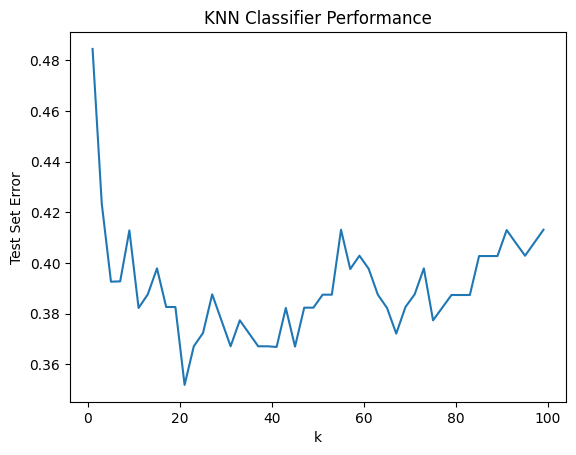

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


In [38]:
# Pick k for KNN without feature extraction/selection

# Define a list of k values to test
k_values = list(range(1, 100, 2))

# Train a KNN classifier for each k value and record the test set accuracy
errors = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform')
    scores = cross_val_score(knn, x_kbest, y_gist, cv=5)
    errors.append(1-scores.mean())

# Create a line plot of k vs. test set accuracy
plt.plot(k_values, errors)
plt.xlabel('k')
plt.ylabel('Test Set Error')
plt.title('KNN Classifier Performance')
plt.show()
print(k_values)

Best parameters: {'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}
Best accuracy: 0.6383333333333333
Best ROC AUC score: 0.7014736842105262


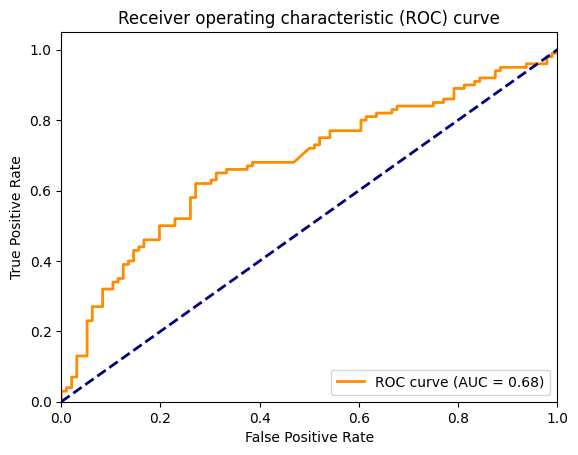

In [25]:
#Hyperparameter optimalization - Non linear SVM - SelectKBest Christie
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

#parameter grid --> gridsearch
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'degree': [2, 3, 4],
    'coef0': [0, 1, 2]
}

# Initialize an instance of the SVC class with initial hyperparameters
svc = SVC(probability=True)

# Perform grid search cross-validation to find the optimal hyperparameters
# Create a GridSearchCV object to search over the parameter grid using accuracy and ROC AUC score
scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring=scoring, refit='roc_auc')
grid_search.fit(x_kbest, y_gist)

# Print the best hyperparameters and both accuracy and ROC AUC score found by GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Best ROC AUC score:", grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])

#toegevoegd 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_gist, grid_search.predict_proba(x_kbest)[:, 1])

# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# RandomForest ensemble with cross_val - selectKBest

k = 100
x_kbest = kbest_func(x_scaled,k)

params = {'n_estimators': [1, 2, 5, 10, 20, 30, 40, 50, 100]}

# Run grid search with 50 fold cross validation on forest classifier
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, cv=5)
grid = grid.fit(x_kbest, y_train)

print(grid.cv_results_)
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
# Random forrest attempt Harmen ROC outcome
from sklearn.metrics import roc_auc_score


# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=100)

# Fit the random forest classifier on the training data
rfc.fit(x_scaled, y_train)

# Evaluate the random forest classifier on the testing data
scores = cross_val_score(rfc, x_scaled, y_train, cv=10)
scores_roc = cross_val_score(rfc, x_scaled, y_train, cv=10, scoring='roc_auc')


print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(scores.mean()*100, scores.std()*100))
print("ROC: {:.2f}% (+/- {:.2f}%)".format(scores_roc.mean()*100, scores_roc.std()*100))

Accuracy: 61.74% (+/- 7.98%)
ROC: 64.61% (+/- 9.79%)


Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
Best accuracy: 0.668974358974359
Best ROC AUC score: 0.679078947368421


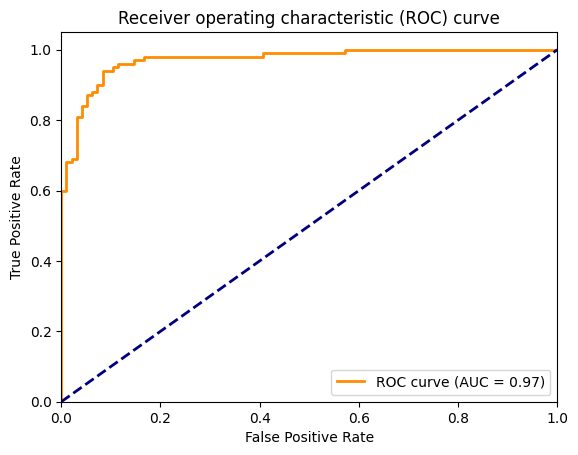

In [30]:
# Random forrest with grid search Harmen

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [5, 10, 15, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random forest
rf = RandomForestClassifier()

# Create a GridSearchCV object to search over the parameter grid using accuracy and ROC AUC score
scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=scoring, refit='roc_auc')

# Fit the GridSearchCV object to the data
grid_search.fit(x_kbest, y_gist)

# Print the best hyperparameters and both accuracy and ROC AUC score found by GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_])
print("Best ROC AUC score:", grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_])

#toegevoegd 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_gist, grid_search.predict_proba(x_kbest)[:, 1])

# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# #Evaluatie van het model uiteindelijk met outer cross validatie 
# from sklearn.model_selection import KFold 
# from sklearn.metrics import accuracy_score 

# #dit moet helemaal bovenaan de code 
# from sklearn.model_selection import train_test_split, KFold, GridSearchCV 

# y = data['label']
# x = df2
# # Define outer cross-validation
# outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# outer_scores = []

# for train_index, test_index in outer_cv.split(x):
#     # Split data into outer training and test sets
#     X_train_outer, X_test = x[train_index], x[test_index] # dit zorgt ervoor dat hij hem splitst in outer in een train en test set 
#     y_train_outer, y_test = y[train_index], y[test_index]

#     # Define inner cross-validation
#     inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
#     inner_scores = []

#     for inner_train_index, inner_test_index in inner_cv.split(X_train_outer):
#         # Split data into inner training and validation sets      --> hier moet de code komen die we al hebben met de juiste classifier --> kunnen het makkelijk maken door hier gewoon de nieuwe classifier in te plakkken, wel beetje omslachtig maar wel t makkelijkste 
#         X_train_inner, X_val = X_train_outer[inner_train_index], X_train_outer[inner_test_index]
#         y_train_inner, y_val = y_train_outer[inner_train_index], y_train_outer[inner_test_index]

#         # Split inner training set into training and validation sets
#         X_train, X_test_inner, y_train, y_test_inner = train_test_split(X_train_inner, y_train_inner, test_size=0.2, random_state=42)

# # hier komt ons model + scaling en feature selectie 
       
#        #LET OP HIER MOET DE JUISTE SCALING WORDEN AANGEPAST 
#         # scale data
#         scaler = preprocessing.RobustScaler()
#         scaler.fit(x_train)
#         x_scaled = pd.DataFrame(scaler.transform(non_normalized))


#       #HIER MOET DE CODE KOMEN DIE UITEINDELIJK GEKOZEN IS VOOR DE CLASSIFIER 
#         # Evaluate model on inner validation set
#         inner_score = grid_search.score(X_val, y_val)
#         inner_scores.append(inner_score)

#     # Train model on outer training set with best hyperparameters
#     best_params = grid_search.best_params_
#     model = SVC(**best_params)
#     model.fit(X_train_outer, y_train_outer)

#     # Evaluate model on outer test set
#     outer_score = model.score(X_test, y_test)
#     outer_scores.append(outer_score)

# # Print average outer cross-validation score
# print('Outer CV score:', np.mean(outer_scores))

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

#knn gebruiken als een classifier 
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1) 
clf = knn
title = "knn"
plot_learning_curve(clf, title, x, y, ax, ylim=(0.3, 1.01), cv=10)


from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1) 
title = "descision tree"
plot_learning_curve(clf, title, x, y, ax, ylim=(0.3, 1.01), cv=10)


from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1) 
title = "Gaussian NB"
plot_learning_curve(clf, title, x, y, ax, ylim=(0.3, 1.01), cv=10)
